=== Challenger O-ring Failure Analysis ===
Number of observations: 23
Temperature range: 53.0°F to 81.0°F
Total failures: 12

Parameter estimates:
MLE: α = -3.101, β = -1.333
MAP: α = -2.562, β = -1.010
Posterior mean: α = -2.616, β = -1.058


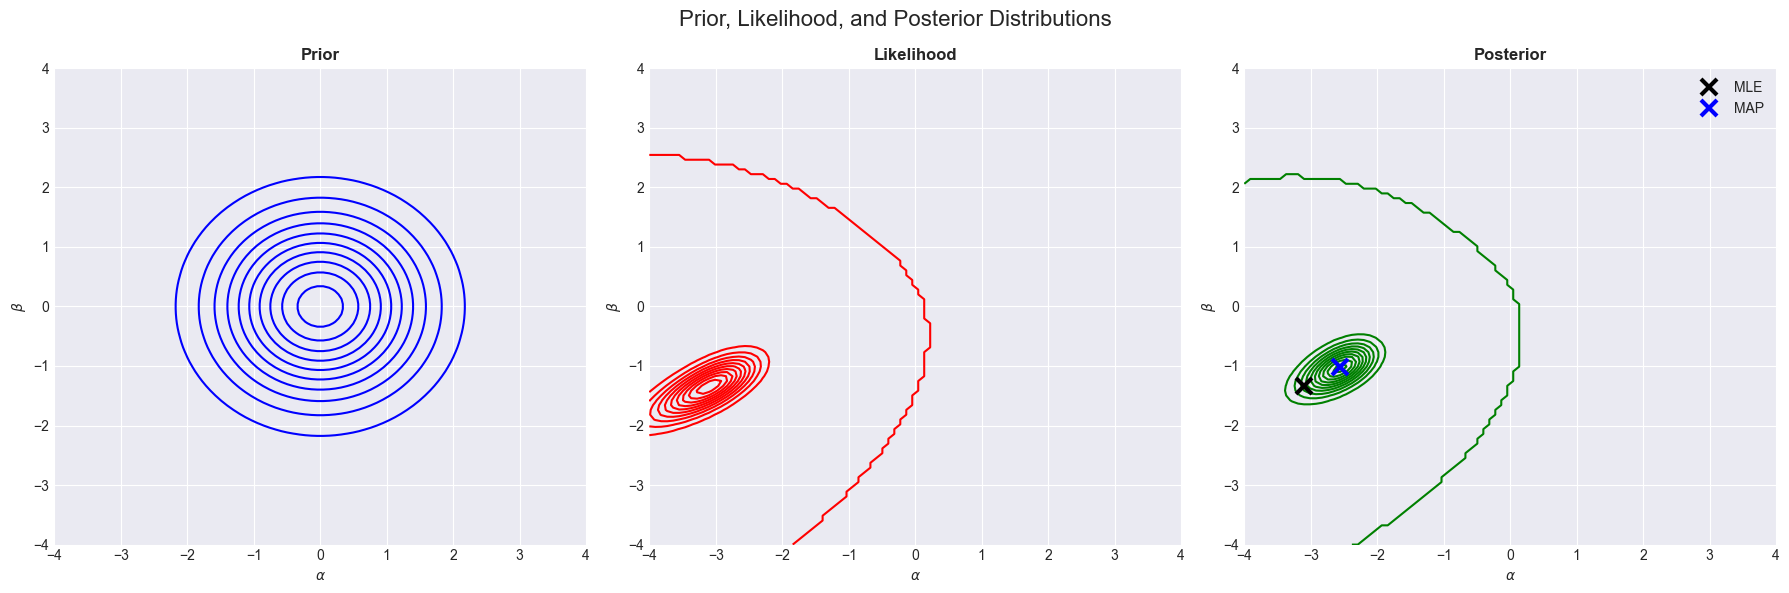

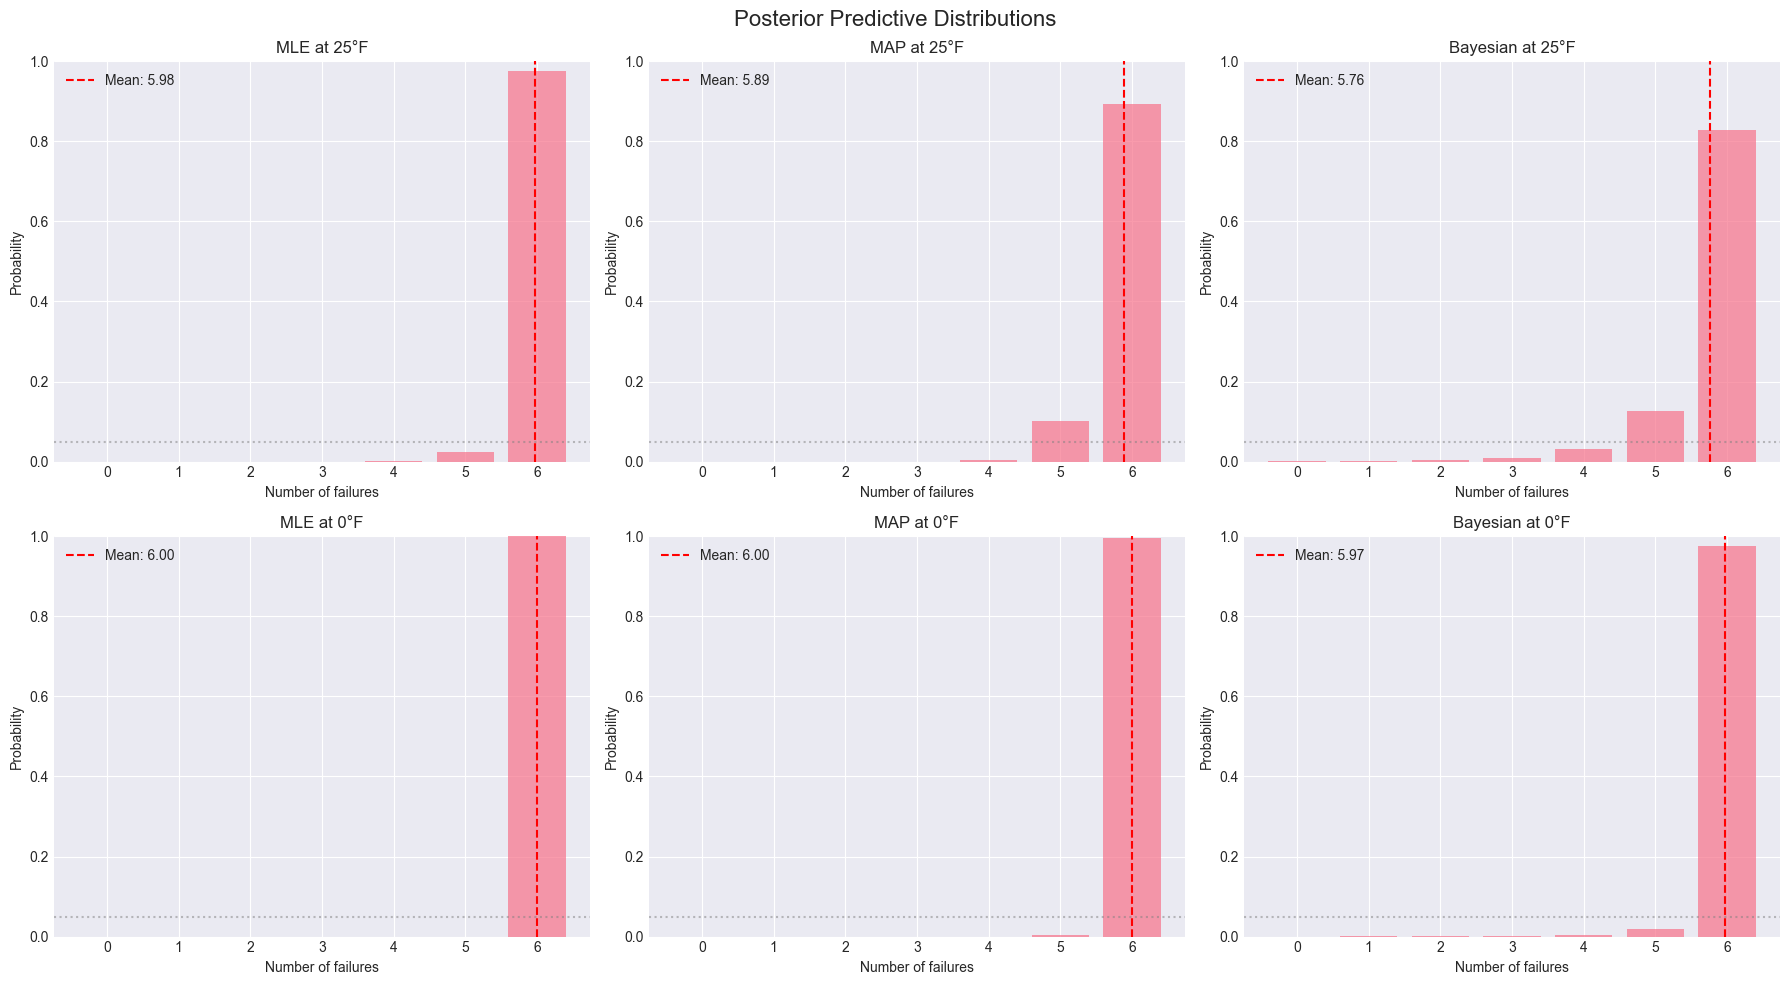

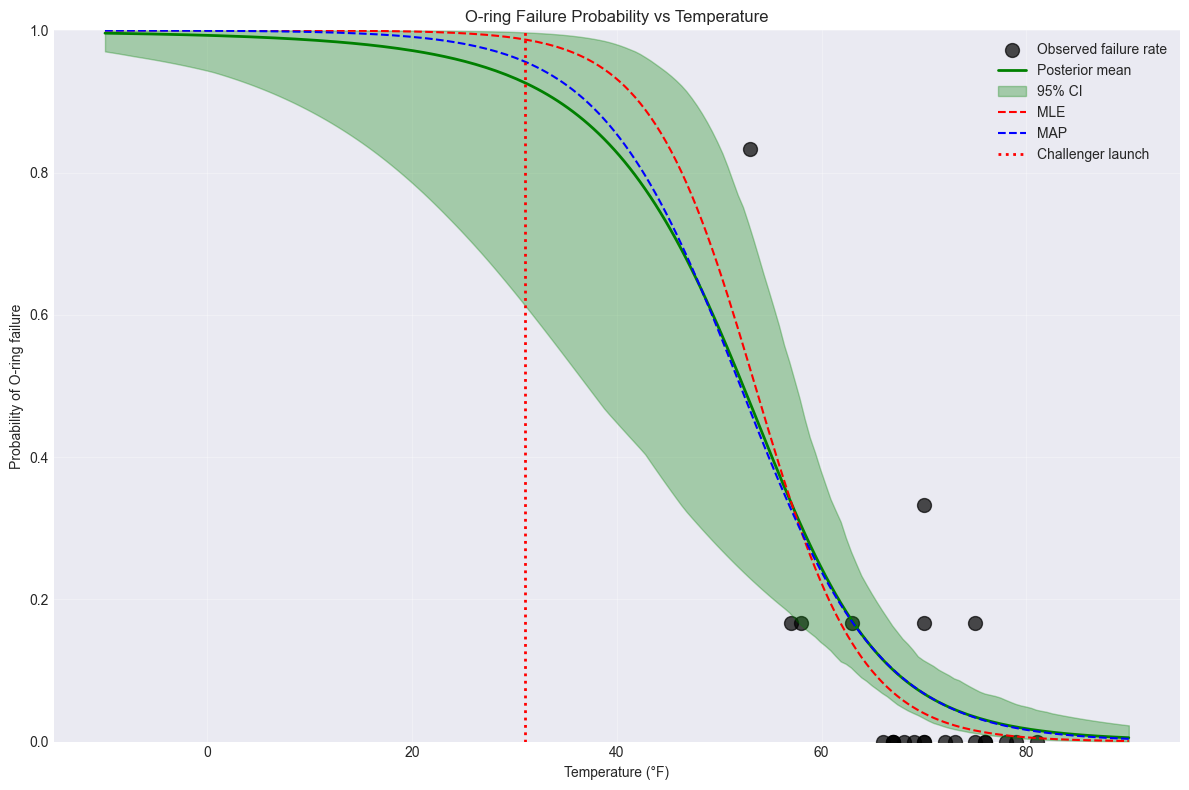


=== Prediction Summary ===

Temperature: 31°F
  P(single O-ring failure): 0.927 [0.927, 0.927]
  P(at least one failure): 0.999 [0.997, 1.000]
  Expected failures: 5.559 [3.682, 5.983]

Temperature: 50°F
  P(single O-ring failure): 0.580 [0.580, 0.580]
  P(at least one failure): 0.980 [0.852, 1.000]
  Expected failures: 3.481 [1.634, 5.022]

Temperature: 70°F
  P(single O-ring failure): 0.067 [0.067, 0.067]
  P(at least one failure): 0.336 [0.180, 0.516]
  Expected failures: 0.403 [0.196, 0.684]


In [1]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from jax import random
import jax.scipy.stats as jstats
import scipy.stats as stats
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Optional

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Sigmoid function
sigmoid = lambda x: 1. / (1 + jnp.exp(-x))

# Log Normal PDF for priors
log_npdf = lambda x, m, v: -(x - m)**2 / (2 * v) - 0.5 * jnp.log(2 * jnp.pi * v)

class LogisticRegression(object):
    """
    Logistic regression model for binomial outcomes.
    θ(x) = σ(α + βx) where σ is the sigmoid function
    """
    
    def __init__(self, x, y, N, sigma2_alpha=1., sigma2_beta=1.):
        """
        Initialize the logistic regression model.
        
        Args:
            x: Input features (temperatures)
            y: Outcomes (number of failures)
            N: Number of trials per observation
            sigma2_alpha: Prior variance for intercept
            sigma2_beta: Prior variance for slope
        """
        self.x = x 
        self.y = y
        self.N = N
        self.sigma2_alpha = sigma2_alpha
        self.sigma2_beta = sigma2_beta

    def f(self, x, alpha, beta):
        """Linear function f(x) = α + βx"""
        return alpha + x * beta

    def theta(self, x, alpha, beta):
        """Probability function θ(x) = σ(f(x))"""
        return sigmoid(self.f(x, alpha, beta))

    def log_prior(self, alpha, beta):
        """Log prior for parameters, assuming independent Gaussians"""
        return log_npdf(alpha, 0, self.sigma2_alpha) + log_npdf(beta, 0, self.sigma2_beta)

    def log_likelihood(self, alpha, beta):
        """Log likelihood of the data given parameters"""
        theta = self.theta(self.x, alpha, beta)
        # Use JAX's binomial logpmf
        log_lik = jnp.sum(jstats.binom.logpmf(self.y, self.N, theta), axis=-1, keepdims=True)
        return log_lik

    def log_joint(self, alpha, beta):
        """Log joint distribution = log prior + log likelihood"""
        return self.log_prior(alpha, beta).squeeze() + self.log_likelihood(alpha, beta).squeeze()


class Grid2D(object):
    """Helper class for evaluating functions on a 2D grid"""
    
    def __init__(self, alphas, betas, func, name="Grid2D"):
        """Initialize the Grid2D object"""
        self.alphas = alphas
        self.betas = betas
        self.grid_size = (len(self.alphas), len(self.betas))
        self.alpha_grid, self.beta_grid = jnp.meshgrid(alphas, betas, indexing='ij')
        self.func = func
        self.name = name
        
        # Evaluate function on the grid
        self.values = self.func(self.alpha_grid[:, :, None], self.beta_grid[:, :, None]).squeeze()

    def plot_contours(self, ax, color='b', num_contours=10, f=lambda x: x, alpha=1.0, title=None):
        """Plot contour lines for the function"""
        ax.contour(self.alphas, self.betas, f(self.values).T, num_contours, colors=color, alpha=alpha)
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(self.name if title is None else title, fontweight='bold')

    @property
    def argmax(self):
        """Return (α, β) corresponding to the maximum value"""
        idx = jnp.argmax(self.values)
        alpha_idx, beta_idx = jnp.unravel_index(idx, self.grid_size)
        return self.alphas[alpha_idx], self.betas[beta_idx]


class GridApproximation2D(Grid2D):
    """Approximates the posterior using a 2D grid"""
    
    def __init__(self, alphas, betas, log_joint, threshold=1e-8, name="GridApproximation2D"):
        """Initialize the grid approximation"""
        Grid2D.__init__(self, alphas, betas, log_joint, name)
        self.threshold = threshold
        self.prep_approximation()
        self.compute_marginals()
        self.sanity_check()

    def prep_approximation(self):
        """Prepare the grid approximation"""
        # Log joint values
        self.log_joint_grid = self.values
        
        # Numerical stability: subtract max
        self.log_joint_grid = self.log_joint_grid - jnp.max(self.log_joint_grid)
        
        # Exponentiate to get unnormalized probabilities
        self.tilde_probabilities_grid = jnp.exp(self.log_joint_grid)
        
        # Normalize
        self.Z = jnp.sum(self.tilde_probabilities_grid)
        self.probabilities_grid = self.tilde_probabilities_grid / self.Z
        
        # Flatten for convenience
        self.alphas_flat = self.alpha_grid.flatten()
        self.betas_flat = self.beta_grid.flatten()
        self.num_outcomes = len(self.alphas_flat)
        self.probabilities_flat = self.probabilities_grid.flatten()

    def compute_marginals(self):
        """Compute marginal distributions"""
        self.pi_alpha = jnp.sum(self.probabilities_grid, axis=1)
        self.pi_beta = jnp.sum(self.probabilities_grid, axis=0)

    def compute_expectation(self, f):
        """Compute expectation E[f(α, β)]"""
        return jnp.sum(f(self.alphas_flat, self.betas_flat) * self.probabilities_flat, axis=0)

    def sample(self, key, num_samples=1):
        """Generate samples from the grid approximation"""
        idx = random.choice(key, jnp.arange(self.num_outcomes), 
                          p=self.probabilities_flat, shape=(num_samples, 1))
        return self.alphas_flat[idx], self.betas_flat[idx]

    def visualize(self, ax, scaling=8000, title='Grid approximation'):
        """Visualize the grid approximation"""
        idx = self.probabilities_flat > self.threshold
        ax.scatter(self.alphas_flat[idx], self.betas_flat[idx], 
                  scaling * self.probabilities_flat[idx], label='$\\pi_{ij}$')
        ax.set(xlabel='$\\alpha$', ylabel='$\\beta$')
        ax.set_title(title, fontweight='bold')

    def sanity_check(self):
        """Check that probabilities are valid"""
        assert self.probabilities_grid.shape == self.grid_size
        assert jnp.all(self.probabilities_grid >= 0)
        assert jnp.allclose(self.probabilities_grid.sum(), 1)


class DiscreteDistribution1D(object):
    """Discrete distribution for outcomes"""
    
    def __init__(self, outcomes, probabilities, name='DiscreteDistribution'):
        self.outcomes = outcomes
        self.probabilities = probabilities
        assert self.outcomes.shape == self.probabilities.shape
        self.name = name

    def CDF(self, x):
        """Cumulative distribution function"""
        idx = self.outcomes <= x
        return jnp.sum(self.probabilities[idx])
    
    def quantile(self, p):
        """Quantile function"""
        cdf_values = jnp.cumsum(self.probabilities)
        idx = jnp.where(jnp.logical_or(p < cdf_values, jnp.isclose(p, cdf_values)))[0]
        return jnp.min(self.outcomes[idx])
    
    @property
    def mean(self):
        """Expected value"""
        return jnp.sum(self.outcomes * self.probabilities)
    
    @property
    def variance(self):
        """Variance"""
        return jnp.sum((self.outcomes - self.mean)**2 * self.probabilities)
    
    def central_interval(self, interval_size=95):
        """Central credibility interval"""
        c = 1. - interval_size / 100.
        lower = self.quantile(c / 2)
        upper = self.quantile(1 - c / 2)
        return jnp.array([lower, upper])
    
    def print_summary(self):
        """Print summary statistics"""
        print(f'Summary for {self.name}')
        print(f'\tMean:\t\t\t\t{self.mean:3.2f}')
        print(f'\tStd. dev.:\t\t\t{jnp.sqrt(self.variance):3.2f}')
        print(f'\t95%-credibility interval:\t[{self.central_interval()[0]:3.2f}, {self.central_interval()[1]:3.2f}]\n')


# Main example: Challenger O-ring failure analysis
def challenger_example():
    """Complete analysis of the Challenger O-ring failure data"""
    
    # Generate synthetic O-ring failure data
    np.random.seed(42)
    
    # Challenger data (simplified)
    temperatures = np.array([53, 57, 58, 63, 66, 67, 67, 67, 68, 69, 70, 70, 
                           70, 70, 72, 73, 75, 75, 76, 76, 78, 79, 81])
    failures = np.array([5, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0])
    N = 6  # Number of O-rings per flight
    
    # Standardize temperatures
    tmean = np.mean(temperatures)
    tstd = np.std(temperatures)
    x = (temperatures - tmean) / tstd
    y = failures
    
    print("=== Challenger O-ring Failure Analysis ===")
    print(f"Number of observations: {len(x)}")
    print(f"Temperature range: {temperatures.min():.1f}°F to {temperatures.max():.1f}°F")
    print(f"Total failures: {failures.sum()}")
    
    # Set up the model
    model = LogisticRegression(x, y, N, sigma2_alpha=1.0, sigma2_beta=1.0)
    
    # Define grid for (α, β)
    num_alpha, num_beta = 90, 100
    alphas = jnp.linspace(-4, 4, num_alpha)
    betas = jnp.linspace(-4, 4, num_beta)
    
    # Compute prior, likelihood, and posterior grids
    log_prior_grid = Grid2D(alphas, betas, model.log_prior, 'Prior')
    log_lik_grid = Grid2D(alphas, betas, model.log_likelihood, 'Likelihood')
    log_joint_grid = Grid2D(alphas, betas, model.log_joint, 'Posterior')
    
    # Find MLE and MAP estimates
    alpha_MLE, beta_MLE = log_lik_grid.argmax
    alpha_MAP, beta_MAP = log_joint_grid.argmax
    
    print(f"\nParameter estimates:")
    print(f"MLE: α = {alpha_MLE:.3f}, β = {beta_MLE:.3f}")
    print(f"MAP: α = {alpha_MAP:.3f}, β = {beta_MAP:.3f}")
    
    # Create grid approximation
    post_approx = GridApproximation2D(alphas, betas, model.log_joint, name='Posterior')
    
    # Compute posterior means
    post_mean_alpha = post_approx.compute_expectation(lambda a, b: a)
    post_mean_beta = post_approx.compute_expectation(lambda a, b: b)
    print(f"Posterior mean: α = {post_mean_alpha:.3f}, β = {post_mean_beta:.3f}")
    
    # ==== Visualization 1: Prior, Likelihood, and Posterior ====
    fig1, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['blue', 'red', 'green']
    
    # Plot contours
    log_prior_grid.plot_contours(axes[0], f=jnp.exp, color=colors[0])
    log_lik_grid.plot_contours(axes[1], f=jnp.exp, color=colors[1])
    log_joint_grid.plot_contours(axes[2], f=jnp.exp, color=colors[2])
    
    # Add MLE and MAP to posterior plot
    axes[2].plot(alpha_MLE, beta_MLE, 'kx', label='MLE', markersize=12, markeredgewidth=3)
    axes[2].plot(alpha_MAP, beta_MAP, 'bx', label='MAP', markersize=12, markeredgewidth=3)
    axes[2].legend()
    
    fig1.suptitle('Prior, Likelihood, and Posterior Distributions', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # ==== Visualization 2: Posterior Predictive ====
    # Define target temperatures for prediction
    temp_stars = [25, 0]  # Cold temperatures (°F)
    ks = jnp.arange(0, N+1)  # Possible number of failures
    
    fig2, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    for n, t_star in enumerate(temp_stars):
        # Standardize temperature
        x_star = (t_star - tmean) / tstd
        
        # Predictive likelihood function
        pred_lik = lambda k, x, alpha, beta: jstats.binom.pmf(
            k=k, n=N, p=model.theta(x, alpha, beta))
        
        # MLE predictions
        pred_probs_MLE = pred_lik(ks, x_star, alpha_MLE, beta_MLE)
        
        # MAP predictions
        pred_probs_MAP = pred_lik(ks, x_star, alpha_MAP, beta_MAP)
        
        # Full Bayesian predictions
        pred_probs_bayes = jnp.sum(
            post_approx.probabilities_grid[:, :, None] * 
            pred_lik(ks, x_star, 
                    post_approx.alpha_grid[:, :, None], 
                    post_approx.beta_grid[:, :, None]),
            axis=(0, 1))
        
        # Create distributions
        dist_MLE = DiscreteDistribution1D(ks, pred_probs_MLE, 'MLE')
        dist_MAP = DiscreteDistribution1D(ks, pred_probs_MAP, 'MAP')
        dist_bayes = DiscreteDistribution1D(ks, pred_probs_bayes, 'Bayesian')
        
        # Plot
        for i, dist in enumerate([dist_MLE, dist_MAP, dist_bayes]):
            axes[n, i].bar(ks, dist.probabilities, alpha=0.7)
            axes[n, i].set_xlabel('Number of failures')
            axes[n, i].set_ylabel('Probability')
            axes[n, i].set_title(f'{dist.name} at {t_star}°F')
            axes[n, i].set_ylim(0, 1)
            
            # Add mean and interval
            mean_val = dist.mean
            ci = dist.central_interval()
            axes[n, i].axvline(mean_val, color='red', linestyle='--', 
                             label=f'Mean: {mean_val:.2f}')
            axes[n, i].axhline(0.05, color='gray', linestyle=':', alpha=0.5)
            axes[n, i].legend()
    
    fig2.suptitle('Posterior Predictive Distributions', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # ==== Visualization 3: Probability of failure vs temperature ====
    temp_range = np.linspace(-10, 90, 200)
    x_range = (temp_range - tmean) / tstd
    
    # Sample from posterior
    key = random.PRNGKey(0)
    num_samples = 1000
    alpha_samples, beta_samples = post_approx.sample(key, num_samples)
    
    # Compute failure probabilities
    theta_samples = model.theta(x_range, alpha_samples, beta_samples)
    
    # Mean and intervals
    theta_mean = theta_samples.mean(0)
    theta_lower = jnp.quantile(theta_samples, 0.025, axis=0)
    theta_upper = jnp.quantile(theta_samples, 0.975, axis=0)
    
    fig3, ax = plt.subplots(figsize=(12, 8))
    
    # Plot data
    failure_rate = y / N
    ax.scatter(temperatures, failure_rate, s=100, c='black', alpha=0.7, 
              label='Observed failure rate')
    
    # Plot predictions
    ax.plot(temp_range, theta_mean, 'g-', linewidth=2, label='Posterior mean')
    ax.fill_between(temp_range, theta_lower, theta_upper, 
                   color='green', alpha=0.3, label='95% CI')
    
    # Add MLE and MAP predictions
    theta_mle = model.theta(x_range, alpha_MLE, beta_MLE)
    theta_map = model.theta(x_range, alpha_MAP, beta_MAP)
    ax.plot(temp_range, theta_mle, 'r--', label='MLE')
    ax.plot(temp_range, theta_map, 'b--', label='MAP')
    
    # Mark Challenger launch temperature (31°F)
    ax.axvline(31, color='red', linestyle=':', linewidth=2, label='Challenger launch')
    
    ax.set_xlabel('Temperature (°F)')
    ax.set_ylabel('Probability of O-ring failure')
    ax.set_title('O-ring Failure Probability vs Temperature')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # ==== Numerical summary ====
    print("\n=== Prediction Summary ===")
    
    for temp in [31, 50, 70]:  # Challenger, cold, warm
        x_temp = (temp - tmean) / tstd
        
        # Compute predictions
        theta_bayes = model.theta(x_temp, alpha_samples, beta_samples)
        prob_failure = theta_bayes.mean()
        prob_at_least_one = 1 - (1 - theta_bayes) ** N
        mean_failures = N * theta_bayes
        
        print(f"\nTemperature: {temp}°F")
        print(f"  P(single O-ring failure): {prob_failure.mean():.3f} "
              f"[{jnp.quantile(prob_failure, 0.025):.3f}, "
              f"{jnp.quantile(prob_failure, 0.975):.3f}]")
        print(f"  P(at least one failure): {prob_at_least_one.mean():.3f} "
              f"[{jnp.quantile(prob_at_least_one, 0.025):.3f}, "
              f"{jnp.quantile(prob_at_least_one, 0.975):.3f}]")
        print(f"  Expected failures: {mean_failures.mean():.3f} "
              f"[{jnp.quantile(mean_failures, 0.025):.3f}, "
              f"{jnp.quantile(mean_failures, 0.975):.3f}]")


# Run the example
if __name__ == "__main__":
    challenger_example()